# Import

In [2]:
!pip install torchmetrics
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher


from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

ModuleNotFoundError: No module named 'mlxtend'

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np

import os
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Processing data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


EMNIST dataset

In [4]:
def load_dataset(csv_file):
    data = pd.read_csv(csv_file)
    labels = data.iloc[:, 0].values
    images = data.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)
    return images, labels

# Define transform (convert numpy arrays to PyTorch tensors)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load training and testing data
train_images, train_labels = load_dataset('/content/drive/MyDrive/emnist_dataset/emnist-balanced-train.csv')
test_images, test_labels = load_dataset('/content/drive/MyDrive/emnist_dataset/emnist-balanced-test.csv')  # Adjust to your actual test file

class CustomEMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).float()

        if isinstance(label, np.int64):
            label = torch.tensor(label, dtype=torch.long)
        return image, label

# Create instances of CustomEMNISTDataset
train_dataset = CustomEMNISTDataset(images=train_images, labels=train_labels, transform=transform)
test_dataset = CustomEMNISTDataset(images=test_images, labels=test_labels, transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


In [5]:
mapping = {
    0: 48, 1: 49, 2: 50, 3: 51, 4: 52, 5: 53, 6: 54, 7: 55, 8: 56, 9: 57,
    10: 65, 11: 66, 12: 67, 13: 68, 14: 69, 15: 70, 16: 71, 17: 72, 18: 73, 19: 74,
    20: 75, 21: 76, 22: 77, 23: 78, 24: 79, 25: 80, 26: 81, 27: 82, 28: 83, 29: 84,
    30: 85, 31: 86, 32: 87, 33: 88, 34: 89, 35: 90,
    36: 97, 37: 98, 38: 100, 39: 101, 40: 102, 41: 103, 42: 104, 43: 110, 44: 113, 45: 114, 46: 116
}

class_names = [chr(mapping[i]) for i in range(len(mapping))]
class_names


['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

#Helper Function#

**train function**

In [6]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    #     writer.add_scalars(main_tag="Loss",
    #                        tag_scalar_dict={"train_loss": train_loss,
    #                                         "test_loss": test_loss},
    #                        global_step=epoch)

    #     writer.add_scalars(main_tag="Accuracy",
    #                        tag_scalar_dict={"train_acc": train_acc,
    #                                         "test_acc": test_acc},
    #                        global_step=epoch)

    #     writer.add_graph(model=model,
    #                      # Pass in an example input
    #                      input_to_model=torch.randn(32, 1, 28, 28).to(device))

    # writer.close()

    return results


**save model**

In [7]:
def save_model_weights(model: torch.nn.Module, target_dir: str, model_name: str):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "Model name must end with .pth or .pt"

    model_save_path = target_dir_path / model_name

    print(f"[Success] Saving model weights to: {model_save_path}")

    torch.save(obj=model.state_dict(), f=model_save_path)

**set seeds**

In [8]:
def set_seeds(seed: int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

**matplotlib**

In [9]:
def plot_loss_curves(results_list, labels):
    plt.figure(figsize=(15, 7))

    epochs = range(len(results_list[0]["train_loss"]))

    # Plot loss
    plt.subplot(1, 2, 1)
    for results, label in zip(results_list, labels):
        plt.plot(epochs, results["test_loss"], label=f"{label} test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    for results, label in zip(results_list, labels):
        plt.plot(epochs, results["test_acc"], label=f"{label} test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()


In [10]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    target_image = target_image / 255.0

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)

        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

**Creat Writer**

In [ ]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

# Visualize dataset

torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])


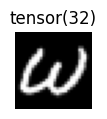

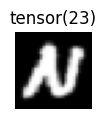

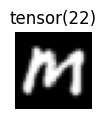

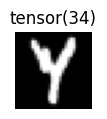

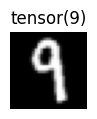

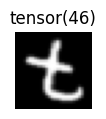

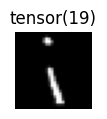

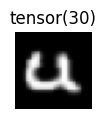

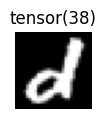

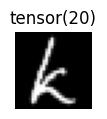

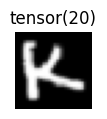

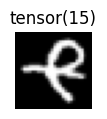

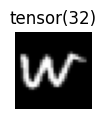

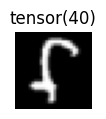

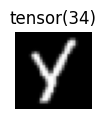

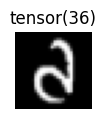

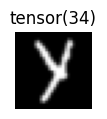

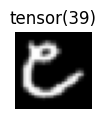

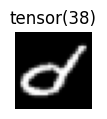

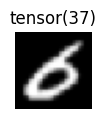

In [11]:
for i in range(40,60):
  img = train_dataset[i][0]
  print(img.shape)
  img_squeeze = img.squeeze()
  img_squeeze = torch.transpose(img_squeeze, 0, 1)
  print(img_squeeze.shape)
  label = train_dataset[i][1]
  plt.figure(figsize=(1, 1))
  plt.imshow(img_squeeze, cmap="gray")
  plt.title(label)
  plt.axis(False);

#MODEL#

**Feed-forward Neural Network**

In [12]:
class FNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=256, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [13]:
set_seeds()

model_fnn = FNN(input_shape=784, #(28x28)
    output_shape=len(class_names)
)
model_fnn.to(device)

FNN(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=256, out_features=47, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fnn.parameters(), lr=0.1)

results_fnn = train(model=model_fnn,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

In [ ]:
save_model_weights(model_fnn, "/content/drive/MyDrive/emnist_dataset/models", "fnn_10_epochs.pth")

In [ ]:
example_writer = create_writer(experiment_name="EMNIST",
                               model_name="fnn",
                               extra="10_epochs")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

**Feed-forward applying PCA**

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# def load_dataset(csv_file):
#     data = pd.read_csv(csv_file)
#     labels = data.iloc[:, 0].values
#     images = data.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)
#     return images, labels

# # Define transform (convert numpy arrays to PyTorch tensors)
# transform = transforms.Compose([
#     transforms.Grayscale(),  # Convert to grayscale
#     transforms.Resize((28, 28)),  # Resize to 28x28 pixels
#     transforms.ToTensor(),
# ])

# # Load training and testing data
# train_images, train_labels = load_dataset('/content/drive/MyDrive/emnist_dataset/emnist-balanced-train.csv')
# test_images, test_labels = load_dataset('/content/drive/MyDrive/emnist_dataset/emnist-balanced-test.csv')

# # Flatten images for PCA
# train_images_flatten = train_images.reshape(train_images.shape[0], -1)
# test_images_flatten = test_images.reshape(test_images.shape[0], -1)

# # Apply PCA
# pca = PCA(n_components=50)  # Reduce to 50 dimensions
# train_images_pca = pca.fit_transform(train_images_flatten)
# test_images_pca = pca.transform(test_images_flatten)

# class CustomPCAEMNISTDataset(Dataset):
#     def __init__(self, images, labels):
#         self.images = images
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         image = self.images[idx].astype(np.float32)
#         label = self.labels[idx]
#         return torch.tensor(image), torch.tensor(label, dtype=torch.long)

# # Create instances of CustomPCAEMNISTDataset
# train_dataset_pca = CustomPCAEMNISTDataset(images=train_images_pca, labels=train_labels)
# test_dataset_pca = CustomPCAEMNISTDataset(images=test_images_pca, labels=test_labels)

# # Create DataLoaders
# train_dataloader_pca = DataLoader(dataset=train_dataset_pca, batch_size=32, shuffle=True)
# test_dataloader_pca = DataLoader(dataset=test_dataset_pca, batch_size=32, shuffle=False)

In [ ]:
# class FNN_PCA(nn.Module):
#     def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
#         super().__init__()
#         self.layer_stack = nn.Sequential(
#             nn.Linear(in_features=input_shape, out_features=512),  # Increased capacity
#             nn.ReLU(),
#             nn.Dropout(p=0.5),  # Moderate dropout
#             nn.Linear(in_features=512, out_features=512),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(in_features=512, out_features=256),
#             nn.ReLU(),
#             nn.Dropout(p=0.3),  # Less dropout in later layers
#             nn.Linear(in_features=256, out_features=256),
#             nn.ReLU(),
#             nn.Dropout(p=0.3),
#             nn.Linear(in_features=256, out_features=output_shape)
#         )

#     def forward(self, x):
#         return self.layer_stack(x)

In [ ]:
# set_seeds()

# model_fnn_pca = FNN_PCA(input_shape=50, #after pca
#     hidden_units=10,
#     output_shape=len(class_names)
# )
# model_fnn_pca.to(device)

FNN_PCA(
  (layer_stack): Sequential(
    (0): Linear(in_features=50, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=47, bias=True)
  )
)

In [ ]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_fnn.parameters(), lr=0.5)

# results_fnn_pca = train(model=model_fnn_pca,
#                     train_dataloader=train_dataloader_pca,
#                     test_dataloader=test_dataloader_pca,
#                     optimizer=optimizer,
#                     loss_fn=loss_fn,
#                     epochs=10,
#                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 24.8183 | train_acc: 0.0215 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 2 | train_loss: 24.8360 | train_acc: 0.0214 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 3 | train_loss: 24.8571 | train_acc: 0.0210 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 4 | train_loss: 24.8225 | train_acc: 0.0211 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 5 | train_loss: 24.8186 | train_acc: 0.0215 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 6 | train_loss: 24.7813 | train_acc: 0.0215 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 7 | train_loss: 24.8262 | train_acc: 0.0214 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 8 | train_loss: 24.8657 | train_acc: 0.0209 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 9 | train_loss: 24.8518 | train_acc: 0.0214 | test_loss: 8.8673 | test_acc: 0.0230
Epoch: 10 | train_loss: 24.7954 | train_acc: 0.0217 | test_loss: 8.8673 | test_acc: 0.0230


**Convolutional Neural Network**

In [14]:
class CNN(torch.nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7,
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [15]:
model_cnn = CNN(input_shape=1,
            hidden_units=10,
            output_shape=len(class_names)).to(device)
model_cnn

CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=47, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.1)


In [ ]:
results_cnn = train(model=model_cnn,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

In [ ]:
save_model_weights(model_cnn, "/content/drive/MyDrive/emnist_dataset/models", "cnn_10_epochs.pth")

**VGG Model**

In [16]:
class VGG_16(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGG_16, self).__init__()
        self.in_channels = in_channels
        self.conv_layer = self.create_conv_layers([
            64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M'
        ])  # Reduced one 'M' to adapt to smaller image size
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),  # Adjusted from 512*7*7 to 512*1*1 due to smaller final feature map size
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(out_channels),  # Corrected parameter here
                    nn.ReLU())]
                in_channels = out_channels
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.linear_layer(x)
        return x


In [17]:
model_vgg = VGG_16(1, len(class_names)).to(device)
model_vgg

VGG_16(
  (conv_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (5): MaxPool2d(kerne

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.05)

In [ ]:
results_vgg = train(model=model_vgg,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

In [ ]:
save_model_weights(model_vgg, "/content/drive/MyDrive/emnist_dataset/models", "vgg_10_epochs.pth")

**LeNet**

In [18]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=len(class_names)):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=6,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,
                         stride=2),
            nn.Conv2d(in_channels=6,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,
                         stride=2),
            nn.Conv2d(in_channels=16,
                      out_channels=120,
                      kernel_size=5,
                      stride=1,
                      padding=0),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.block(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [19]:
model_lenet = LeNet().to(device)
model_lenet

LeNet(
  (block): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=47, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lenet.parameters(), lr=0.1)

In [ ]:
results_lenet = train(model=model_lenet,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

In [ ]:
save_model_weights(model_lenet, "/content/drive/MyDrive/emnist_dataset/models", "lenet_10_epochs.pth")

**Vision Transformer**

In [ ]:
# from torch.utils.data import SubsetRandomSampler

# def load_dataset(csv_file):
#     data = pd.read_csv(csv_file)
#     labels = data.iloc[:, 0].values
#     images = data.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)
#     return images, labels

# # Define transform
# transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# # Load training and testing data
# train_images, train_labels = load_dataset('/content/drive/MyDrive/emnist_dataset/emnist-balanced-train.csv')
# test_images, test_labels = load_dataset('/content/drive/MyDrive/emnist_dataset/emnist-balanced-test.csv')

# class CustomEMNISTDataset(Dataset):
#     def __init__(self, images, labels, transform=None):
#         self.images = images
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.labels[idx]
#         image = Image.fromarray(image)  # Convert numpy array to PIL Image

#         if self.transform:
#             image = self.transform(image)

#         return image, label

# # Calculate indices for each class
# class_indices = {}
# for idx, label in enumerate(train_labels):
#     if label in class_indices:
#         class_indices[label].append(idx)
#     else:
#         class_indices[label] = [idx]

# # Sample 10 indices for each class
# sample_indices = []
# for label, indices in class_indices.items():
#     sampled = np.random.choice(indices, 10, replace=False)
#     sample_indices.extend(sampled)

# # Create SubsetRandomSampler for the training data
# train_sampler = SubsetRandomSampler(sample_indices)

# # Create instances of CustomEMNISTDataset
# small_train_dataset = CustomEMNISTDataset(images=train_images, labels=train_labels, transform=transform)
# small_test_dataset = CustomEMNISTDataset(images=test_images, labels=test_labels, transform=transform)

# # Create DataLoaders with SubsetRandomSampler
# small_train_dataloader = DataLoader(dataset=small_train_dataset, batch_size=32, sampler=train_sampler, shuffle=False)
# small_test_dataloader = DataLoader(dataset=small_test_dataset, batch_size=32, shuffle=False)


In [ ]:
# class PatchEmbedding(nn.Module):
#   def __init__(self, embedding_dim=768, patch_size=16, in_channels=3):
#     super().__init__()

#     self.patch_size = patch_size

#     self.patcher = nn.Conv2d(in_channels=in_channels,
#                              out_channels=embedding_dim,
#                              kernel_size=patch_size,
#                              stride=patch_size,
#                              padding=0)

#     self.flatten = nn.Flatten(start_dim=2,
#                               end_dim=3)

#   def forward(self, x):
#     assert x.shape[-1] % self.patch_size == 0, "img_size phai chia het cho patch_size"
#     x = self.patcher(x)
#     x = self.flatten(x)
#     return x.permute(0,2,1)

# class MHABlock(nn.Module):
#   def __init__(self,
#                embedding_dim = 768,
#                attn_dropout=0,
#                num_heads=12):
#     super().__init__()

#     self.layer_norm = nn.LayerNorm(embedding_dim)

#     self.mha_block = nn.MultiheadAttention(embed_dim=embedding_dim,
#                                            num_heads=num_heads,
#                                            dropout=attn_dropout,
#                                            batch_first=True)

#   def forward(self, x):
#     x = self.layer_norm(x)
#     attn_output, _ = self.mha_block(query=x,
#                                     key=x,
#                                     value=x,
#                                     need_weights=False)

#     return attn_output

# class MLPBlock(nn.Module):
#   def __init__(self,
#                embedding_size=768,
#                mlp_size=3072,
#                mlp_dropout=0.1):
#     super().__init__()

#     self.layer_norm = nn.LayerNorm(embedding_size)

#     self.mlp_block = nn.Sequential(
#         nn.Linear(in_features=embedding_size,
#                   out_features=mlp_size),
#         nn.GELU(),
#         nn.Dropout(p=mlp_dropout),
#         nn.Linear(in_features=mlp_size,
#                   out_features=embedding_size),
#         nn.Dropout(p=mlp_dropout)
#     )

#   def forward(self, x):
#     x = self.layer_norm(x)
#     x = self.mlp_block(x)
#     return x


# # x = torch.rand(32,196,768)
# # model = MLPBlock()
# # model(x).shape

# class TransformerEncoderBlock(nn.Module):
#   def __init__(self,
#                embedding_size=768,
#                mlp_size=3072,
#                num_heads=12,
#                attn_dropout=0,
#                mlp_dropout=0.1):
#     super().__init__()

#     self.mha = MHABlock(embedding_size, attn_dropout, num_heads)

#     self.mlp = MLPBlock(embedding_size, mlp_size, mlp_dropout)

#   def forward(self, x):
#     x = self.mha(x) + x
#     x = self.mlp(x) + x
#     return x


# # x = torch.rand(32,196,768)
# # model = TransformerEncoderBlock()
# # model(x).shape

# class ViT(nn.Module):
#     def __init__(self,
#                  img_size:int=224,
#                  in_channels:int=1,
#                  patch_size:int=16,
#                  num_transformer_layers:int=12,
#                  embedding_dim:int=768,
#                  mlp_size:int=3072,
#                  num_heads:int=12,
#                  attn_dropout:float=0,
#                  mlp_dropout:float=0.1,
#                  embedding_dropout:float=0.1,
#                  num_classes:int=1000):
#         super().__init__()

#         assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

#         self.num_patches = (img_size * img_size) // patch_size**2

#         self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
#                                             requires_grad=True)

#         self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
#                                                requires_grad=True)

#         self.embedding_dropout = nn.Dropout(p=embedding_dropout)

#         self.patch_embedding = PatchEmbedding(in_channels=in_channels,
#                                               patch_size=patch_size,
#                                               embedding_dim=embedding_dim)


#         self.transformer = nn.Sequential(*[TransformerEncoderBlock(embedding_dim, mlp_size, num_heads, attn_dropout, mlp_dropout)
#                                       for _ in range(num_transformer_layers)])

#         self.classifier = nn.Sequential(
#             nn.LayerNorm(normalized_shape=embedding_dim),
#             nn.Linear(in_features=embedding_dim,
#                       out_features=num_classes)
#         )

#     def forward(self, x):
#         batch_size = x.shape[0]

#         class_token = self.class_embedding.expand(batch_size, -1, -1)
#         x = self.patch_embedding(x)

#         x = torch.cat((class_token, x), dim=1)

#         x = self.position_embedding + x

#         x = self.embedding_dropout(x)

#         x = self.transformer(x)

#         x = self.classifier(x[:, 0])

#         return x


# vit = ViT(num_classes=len(class_names))
# x = torch.rand(32,1,224,224)
# vit(x).shape


In [ ]:
# optimizer = torch.optim.Adam(params=vit.parameters(),
#                              lr=3e-3,
#                              betas=(0.9, 0.999),
#                              weight_decay=0.3)

# loss_fn = torch.nn.CrossEntropyLoss()

# set_seeds()

# results = train(model=vit,
#                        train_dataloader=small_train_dataloader,
#                        test_dataloader=small_test_dataloader,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=10,
#                        device=device)

 **Transfer Learning**

*Efficientnet*

In [ ]:
# transform_for_transfer_learning_mnist = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.1307]*3,
#                          std=[0.3081]*3)
# ])


# train_dataset_for_transfer_learning = CustomEMNISTDataset(images=train_images, labels=train_labels, transform=transform_for_transfer_learning_mnist)
# test_dataset_for_transfer_learning = CustomEMNISTDataset(images=test_images, labels=test_labels, transform=transform_for_transfer_learning_mnist)

# train_dataloader_for_transfer_learning = DataLoader(dataset=train_dataset_for_transfer_learning, batch_size=32, shuffle=True)
# test_dataloader_for_transfer_learning = DataLoader(dataset=test_dataset_for_transfer_learning, batch_size=32, shuffle=False)

In [ ]:
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
# model_efnet = torchvision.models.efficientnet_b0(weights=weights).to(device)


# for param in model_efnet.features.parameters():
#     param.requires_grad = False

# set_seeds()

# # Recreate the classifier layer and seed it to the target device
# model_efnet.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(in_features=1280,
#                     out_features=len(class_names), # same number of output units as our number of classes
#                     bias=True)).to(device)


# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_efnet.parameters(), lr=0.1)

# results_efnet = train(model=model_efnet,
#                        train_dataloader=train_dataloader_for_transfer_learning,
#                        test_dataloader=test_dataloader_for_transfer_learning,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=10,
#                        device=device)

*ResNet*

In [ ]:
# weights = torchvision.models.ResNet50_Weights.DEFAULT
# model_resnet = torchvision.models.resnet50(weights=weights).to(device)

# for param in model_resnet.parameters():
#     param.requires_grad = False


# set_seeds()


# model_resnet.fc = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(in_features=2048,
#                     out_features=len(class_names),
#                     bias=True)
# ).to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_resnet.fc.parameters(), lr=0.1)
# results_resnet = train(model=model_resnet,
#                        train_dataloader=train_dataloader_for_transfer_learning,
#                        test_dataloader=test_dataloader_for_transfer_learning,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=10,
#                        device=device)


# Experimental Tracking


Feed-forward Neural Network

In [ ]:
class FNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, dropout_rate: float):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=hidden_units, out_features=hidden_units // 2),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate / 2),
            nn.Linear(in_features=hidden_units // 2, out_features=hidden_units // 2),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate / 2),
            nn.Linear(in_features=hidden_units // 2, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
hidden_units = [128,256,512]
lrs= [0.01, 0.1, 0.5]
epoch = [5, 10, 20]
experiment_number = 0
with open("result.txt", "w") as f:
    f.write("")

for epochs in epoch:
  for lr in lrs:
    for hidden_unit in hidden_units:
      set_seeds()
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model with parameters hidden units = {hidden_unit}")
      print(f"[INFO] learning rate: {lr}")
      print(f"[INFO] Number of epochs: {epochs}")
      model = FNN(input_shape=28*28, hidden_units=hidden_unit, output_shape=47, dropout_rate=0.5).to(device)
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
      result = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device)
      save_filepath = f"fnn_{hidden_unit}_hidden_units_{lr}_lr_{epochs}_epochs.pth"
      save_model_weights(model=model,
                        target_dir="models",
                        model_name=save_filepath)
      print("-"*50 + "\n")
      with open("result.txt", "a") as f:
        f.write(f"fnn_{hidden_unit}_hidden_units_{lr}_lr_{epochs}_epochs.pth\n")
        for key, value in result.items():
          f.write(f"{key}: {value}\n")
        f.write("\n"+"-"*50 + "\n")

Convolutional Neural Network

In [ ]:
model_names = ["CNN", "VGG", "LeNet"]
epoch_list = [20]
lrs = [0.01, 0.1, 0.5]
experiment_number = 0

# # Clear the results file
# with open("/content/drive/MyDrive/emnist_dataset/result_cnn.txt", "w") as f:
#     f.write("")

# Perform the grid search
for epochs in epoch_list:
    for lr in lrs:
        for model_name in model_names:
            if model_name == "CNN":
                model = CNN(input_shape=1, hidden_units=10, output_shape=47).to(device)
            elif model_name == "VGG":
                model = VGG_16(1, 47).to(device)
            elif model_name == "LeNet":
                model = LeNet().to(device)

            set_seeds()
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] Learning rate: {lr}")
            print(f"[INFO] Number of epochs: {epochs}")

            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

            result = train(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device
            )

            save_filepath = f"{model_name}_with_{lr}_lr_{epochs}_epochs.pth"
            save_model_weights(
                model=model,
                target_dir="/content/drive/MyDrive/emnist_dataset/models",
                model_name=save_filepath
            )

            print("-" * 50 + "\n")

            with open("/content/drive/MyDrive/emnist_dataset/result_cnn.txt", "a") as f:
                f.write(f"{model_name}_with_{lr}_lr_{epochs}_epochs.pth\n")
                for key, value in result.items():
                    f.write(f"{key}: {value}\n")
                f.write("\n" + "-" * 50 + "\n")


# Plot Result and Visualization





**Plot loss and accuracy curve**

In [20]:
results = ({'train_loss': [2.100570506119559,1.1160211422849209,0.9623627946224619,0.8879388962907994,0.8388395325723269,0.8081463100893278,0.7826560792052154,0.7657022432148034,0.7517114725983735,0.7384554214680449],
  'train_acc': [0.39382692747655,0.6489335964310226,0.6953071379547014,0.7172231754747198,0.7315305422100206,0.7419926790208191,0.7505645161290322,0.7542799130633723,0.758429993136582,0.7638904140928849],
  'test_loss': [0.9224437570490804,0.7242748394203024, 0.6517107128133984,0.6027176686797012,0.5845638319444494,0.5508203198056237,0.5567135181100595, 0.5363123426530637,0.5251339245207456,0.5186674371615153],
  'test_acc': [0.7062783446712019,0.7558638038548753,0.7818523242630386,0.801264880952381,0.8034899376417234,0.8189023526077098,0.8145443594104309,0.8207164115646258,0.8244827097505669,0.8232142857142858]},
 {'train_loss': [0.9793293668572784,0.5133224649357457,0.45715123333195423,0.42769655411759167,0.40884352918106615, 0.3967543205851359,0.3872790651319297,0.37819160862911677,0.37091048204729743,0.3664486701554018],
  'train_acc': [0.7164175817890643,0.8322600663463738,0.8466915465568521,0.854945378631892,0.8598221230839624,0.8635100663463738,0.8656185655456418,0.8675972317547472,0.8690414092884924, 0.8711779341111874],
  'test_loss': [0.5877332523161051,0.5325219129167852,0.47466235777654614,0.44716022842798103,0.44216327497824315,0.4277637750163776,0.42288096667248376,0.41889566435244213,0.42562702398265706,0.4267383479215458],
  'test_acc': [0.8202983276643991,0.8281498015873016,0.8401218820861678,0.84937641723356,0.8550099206349207,0.8510700113378685,0.8557468820861678,0.8626629818594105,0.8587762188208616,0.8590950963718821]},
 {'train_loss': [0.6492575066858995,0.35362541616597076,0.30835018524147095,0.28101586776660054,0.2615395639923976,0.24319899634160894,0.22961771366510092,0.2170594518911754,0.207847836291325,0.19975294524790546],
  'train_acc': [0.7874636810798444,0.8736604895904827,0.8866394989704873,0.8945830473575841,0.9010440974605354,0.9064184397163121,0.9108759437199726,0.9141392129947381,0.91802304964539, 0.9197777968428278],
  'test_loss': [0.3790416714614954,0.34003670998931335,0.315952841553609,0.33610036741105875,0.3012104440562833,0.307789097533745,0.3142441902309656,0.3118481793802004,0.3098766959912213,0.3226291901482662],
  'test_acc': [0.8688669217687075,0.8830038265306122,0.8877409297052155,0.8778486394557823,0.8935267857142857,0.8916808390022675,0.8923115079365079,0.8959715136054421,0.8966695011337869,0.8944302721088434]},
 {'train_loss': [1.101146358484072,0.4747173452821184,0.40548237879225546,0.3702100457092549,0.34635607680107683,0.3283713301847167,0.31628347003396523,0.3031466473961342,0.2910548883702949,0.2832186430164263],
  'train_acc': [0.6671885724090597,0.8342272935255091,0.8546614047128804,0.8661953786318921,0.8743073667353009,0.8790236787920385,0.8808768016472204,0.8849545298558683,0.8895901967513156,0.892278082818577],
  'test_loss': [0.5789553748355025,0.4795065496598377,0.44368117904531307,0.4094192938004829,0.4203027570810245,0.38550771431376535,0.39080503375149095,0.3926534362416081,0.4022002701653915,0.3843510463567717],
  'test_acc': [0.8057893990929705,0.8350729875283447,0.8415497448979592,0.8568629535147393,0.8530753968253969,0.8677508503401361,0.8615929705215419,0.8665958049886622,0.8628082482993198,0.8701495181405896]})

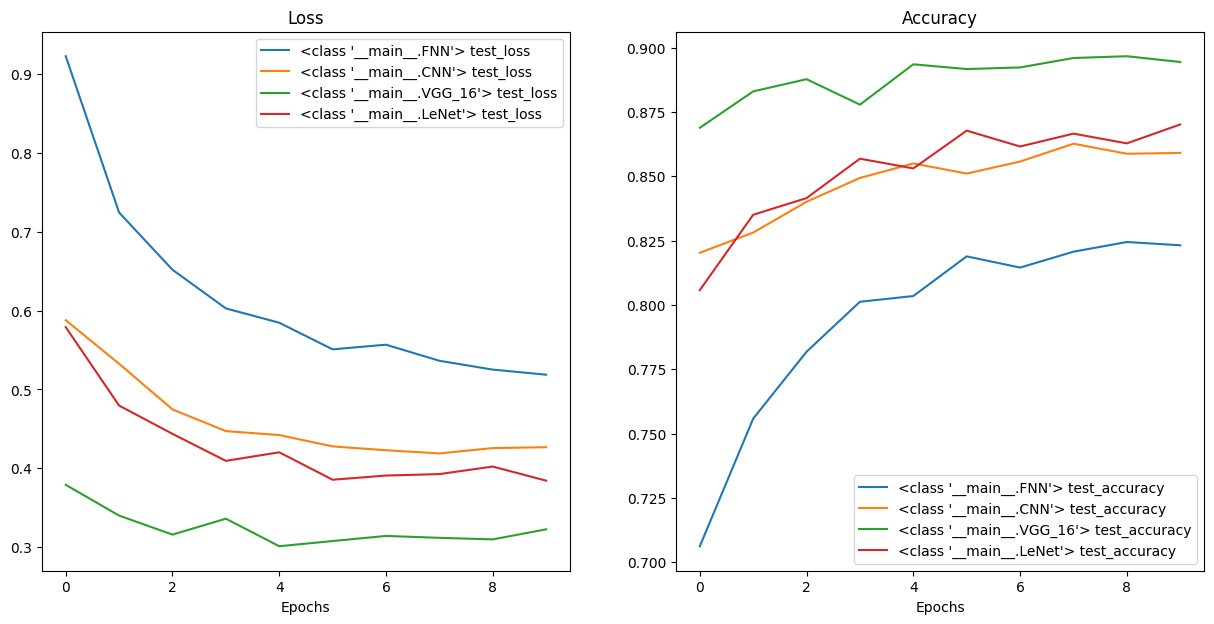

In [21]:
# results = [results_fnn, results_cnn, results_vgg, results_lenet]
labels = [FNN, CNN, VGG_16, LeNet]
plot_loss_curves(results, labels)

**Plot predicted label along with image**

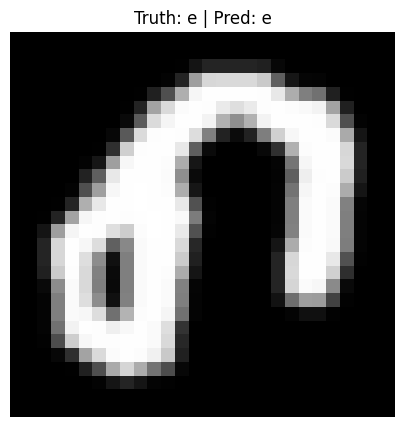

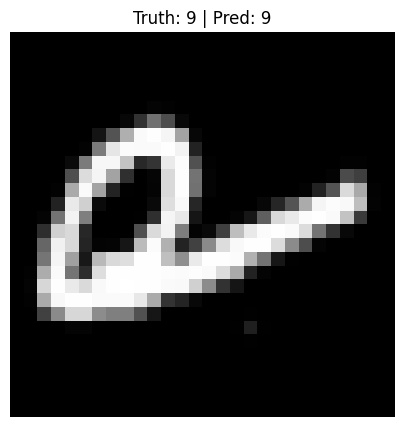

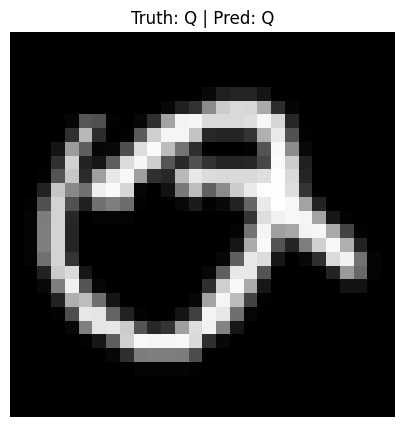

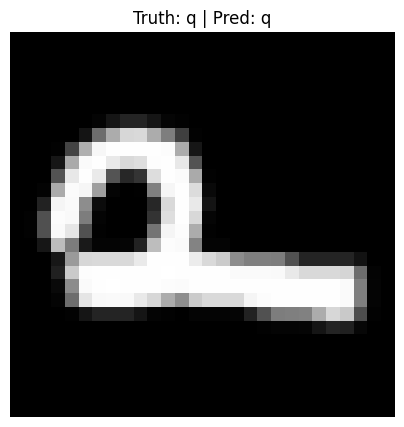

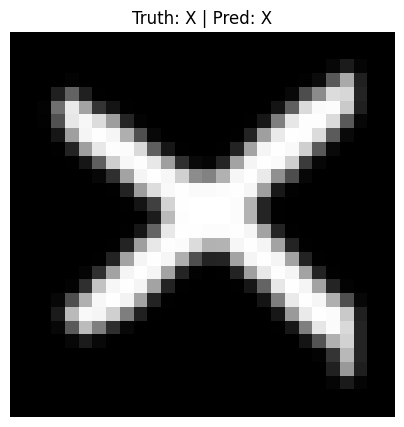

In [22]:
# Initialize the model and load the saved weights
model_vgg = VGG_16(in_channels=1, num_classes=len(class_names))
weights_path = '/content/drive/MyDrive/emnist_dataset/model_cnn/VGG_with_0.5_lr_20_epochs.pth'
model_vgg.load_state_dict(torch.load(weights_path, map_location=device))
model_vgg.to(device)
model_vgg.eval()

# Number of images to plot
num_to_plot = 5

for i in range(num_to_plot):
    # Get image and labels from the test data
    img, label = test_dataset[i]
    img = img.to(device)

    # Make prediction on image
    with torch.no_grad():
        model_pred_logits = model_vgg(img.unsqueeze(0))
        model_pred_probs = torch.softmax(model_pred_logits, dim=1)
        model_pred_label = torch.argmax(model_pred_probs, dim=1)

    # Convert the image to be compatible with matplotlib (if it's a tensor)
    if isinstance(img, torch.Tensor):
        img = img.cpu().squeeze().numpy()

    # Plot the image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    true_label = class_names[label]
    pred_label = class_names[model_pred_label.cpu().item()]
    plt.title(f"Truth: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

**Plot Confusion Matrix**

In [ ]:
# Make predictions on the entire test dataset
test_preds = []
model_vgg.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    test_logits = model_vgg(X)

    pred_probs = torch.softmax(test_logits, dim=1)

    pred_labels = torch.argmax(pred_probs, dim=1)

    test_preds.append(pred_labels)

test_preds = torch.cat(test_preds).view(-1).cpu()
test_truth = torch.cat([y for X, y in test_dataloader])

  0%|          | 0/588 [00:00<?, ?it/s]

In [ ]:
# import pickle

# # Specify the path to your pickle file
# pickle_file_path = '/content/drive/MyDrive/emnist_dataset/GNB-pca-pred'

# # Open the pickle file in binary read mode
# with open(pickle_file_path, 'rb') as file:
#     test_preds = pickle.load(file)


# # Specify the path to your pickle file
# pickle_file_path = '/content/drive/MyDrive/emnist_dataset/GNB-pca-true'

# # Open the pickle file in binary read mode
# with open(pickle_file_path, 'rb') as file:
#     test_truth = pickle.load(file)

# test_preds = torch.Tensor(test_preds)
# test_truth = torch.Tensor(test_truth)


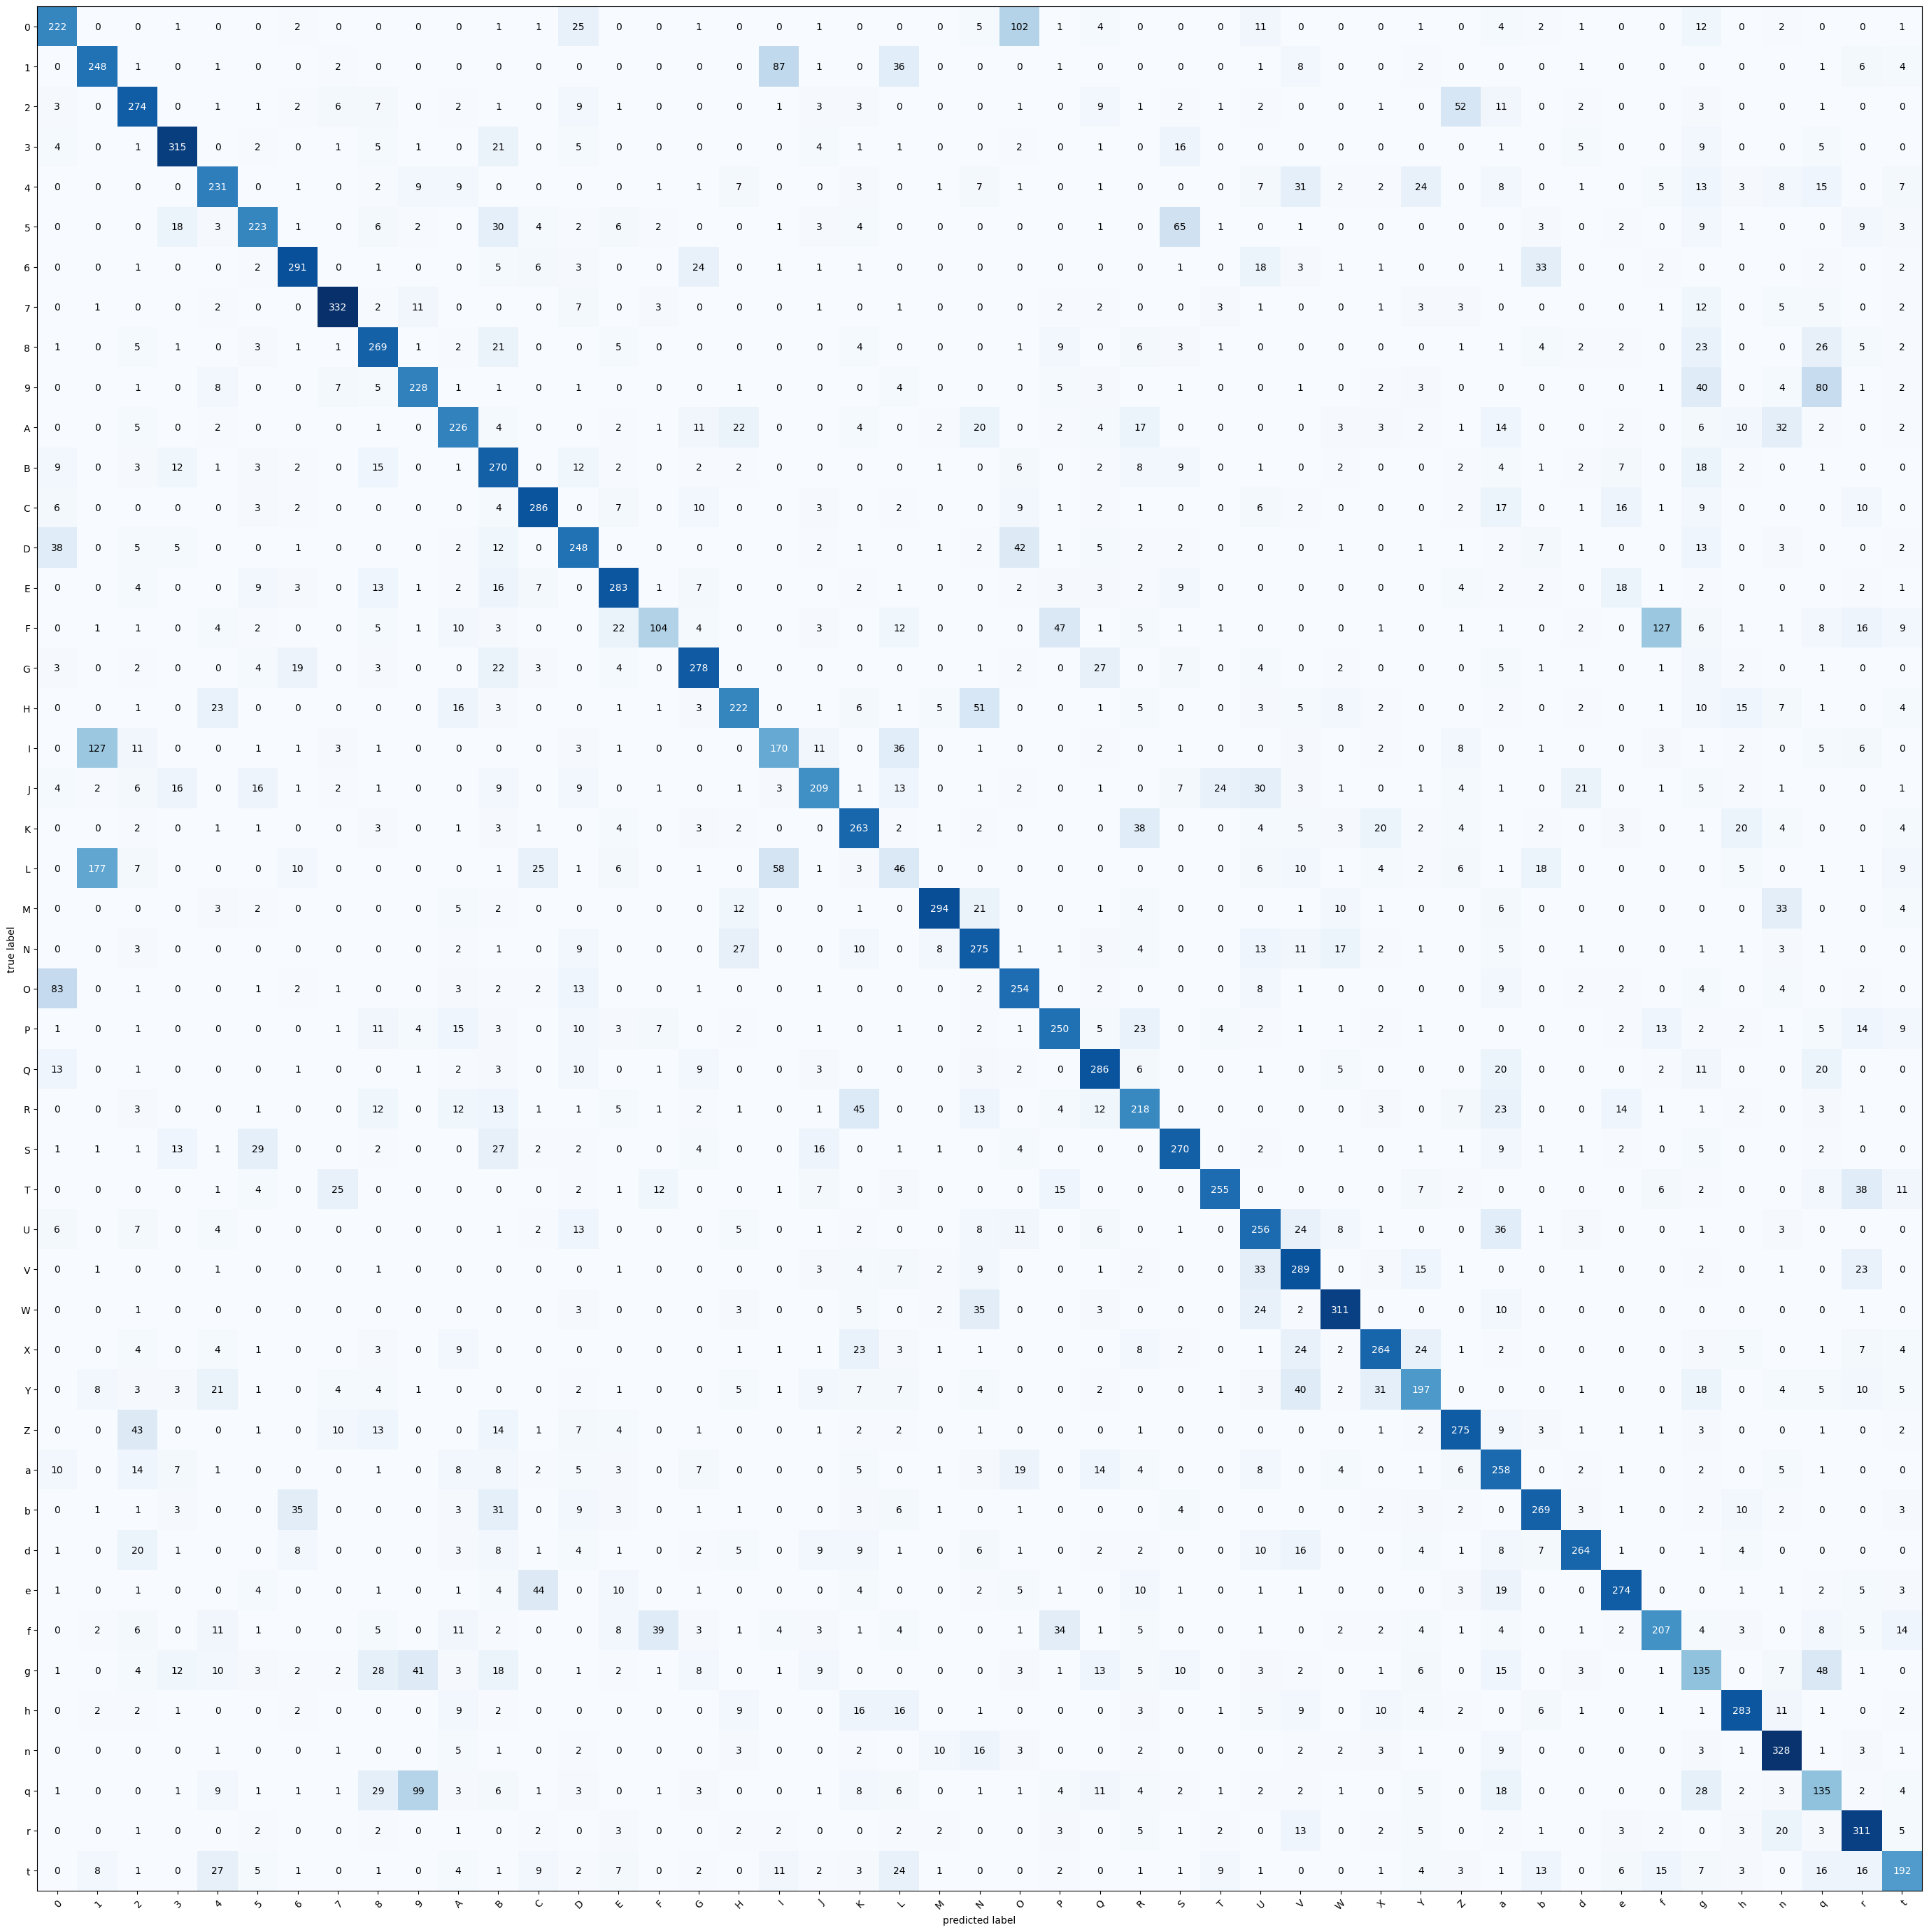

In [ ]:
# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='MULTICLASS')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(50, 35)
)

fig.savefig('confusion_matrix_for_GNB_pca.png')


**Visualize Filter and Neuron in simple CNN**



In [ ]:
model_cnn.load_state_dict(torch.load('/content/drive/MyDrive/emnist_dataset/models/cnn_10_epochs.pth'))

<All keys matched successfully>

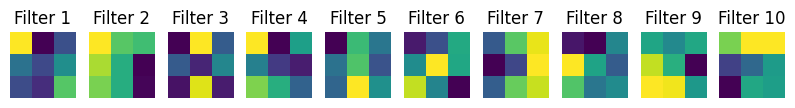

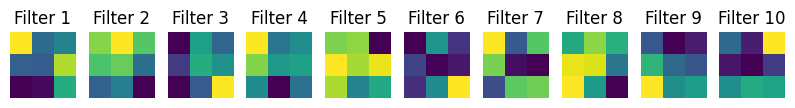

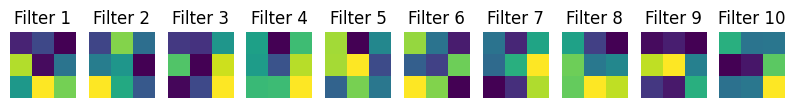

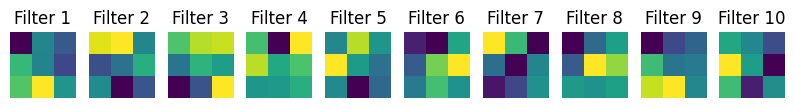

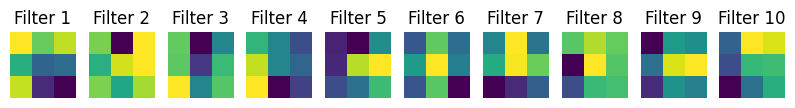

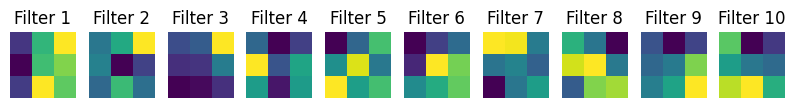

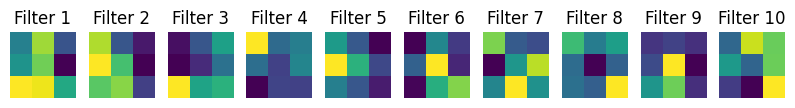

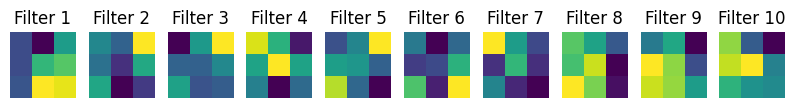

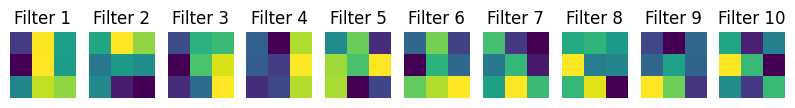

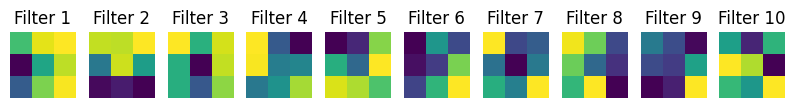

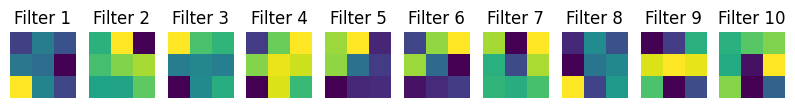

In [ ]:
def plot_filters_single_channel(t):
    nplots = t.shape[0]
    ncols = 10
    nrows = 1 + nplots // ncols
    npimg = np.array(t.detach().cpu().numpy(), np.float32)
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(nplots):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)
        npimg = np.array(t[i].detach().cpu().numpy(), np.float32)
        npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min())
        ax1.imshow(npimg, cmap='viridis')
        ax1.axis('off')
        ax1.set_title(f'Filter {i+1}')
    plt.show()

def plot_filters_multi_channel(t):
    num_kernels = t.shape[0]
    num_channels = t.shape[1]
    for i in range(num_channels):
        plot_filters_single_channel(t[:, i, :, :])

# Plot filters for the first conv layer
filters = model_cnn.conv_block_1[0].weight.data
plot_filters_multi_channel(filters)

filters = model_cnn.conv_block_2[0].weight.data
plot_filters_multi_channel(filters)

In [ ]:
#Visualize Neuron in CNN will be in the next part because we want to use the custom data for vilualizing.

# Deployment Model

In [23]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.5 MB/

In [24]:
model_vgg.to("cpu")

next(iter(model_vgg.parameters())).device

device(type='cpu')

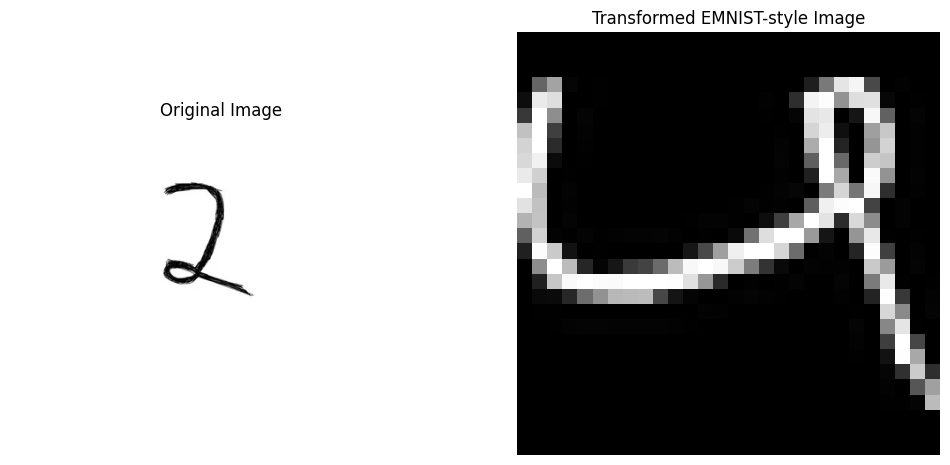

torch.Size([1, 28, 28])

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms
from scipy.ndimage import center_of_mass, shift
import cv2


def transform_image(img):
    """Apply more sophisticated EMNIST transformations to an image and returns a PyTorch tensor."""
    # Convert image to grayscale
    img = img.convert('L')

    # Convert to NumPy array for processing with OpenCV
    img_array = np.array(img)

    # Apply GaussianBlur to reduce noise before thresholding
    img_array = cv2.GaussianBlur(img_array, (5, 5), 0)

    # Apply adaptive thresholding to make the character stand out
    img_array = cv2.adaptiveThreshold(img_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours and the bounding box to center the character
    contours, _ = cv2.findContours(img_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        img_array = img_array[y:y+h, x:x+w]  # Crop to bounding box

    # Resize to 28x28 while preserving aspect ratio and pad to maintain center
    img = Image.fromarray(img_array)
    original_size = img.size
    ratio = 28.0 / max(original_size)
    new_size = tuple([int(x * ratio) for x in original_size])
    img = img.resize(new_size, Image.LANCZOS)

    # Calculate padding to center the image
    delta_w = 28 - new_size[0]
    delta_h = 28 - new_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    img = ImageOps.expand(img, padding, fill=0)

    # Convert back to tensor
    img_tensor = transforms.ToTensor()(img)

    # Ensure the tensor is [1, 28, 28]
    img_tensor = img_tensor.view(1, 28, 28)
    img_tensor = img_tensor.transpose(1, 2)

    return img_tensor

def visualize(img_path):
    """Displays original and transformed images."""
    # Load the image from the specified path
    img = Image.open(img_path)

    # Display the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Transform the image and display
    transformed_img_tensor = transform_image(img)

    plt.subplot(1, 2, 2)
    plt.imshow(transformed_img_tensor.squeeze(0), cmap='gray')
    plt.title('Transformed EMNIST-style Image')
    plt.axis('off')

    plt.show()

def convert_to_EMNIST_data(img_path):
    img = Image.open(img_path)
    transformed_img_tensor = transform_image(img)
    return transformed_img_tensor


# Example usage
img_path = "/content/drive/MyDrive/emnist_dataset/1 (1).webp"
visualize(img_path)
img = convert_to_EMNIST_data(img_path)
img.shape

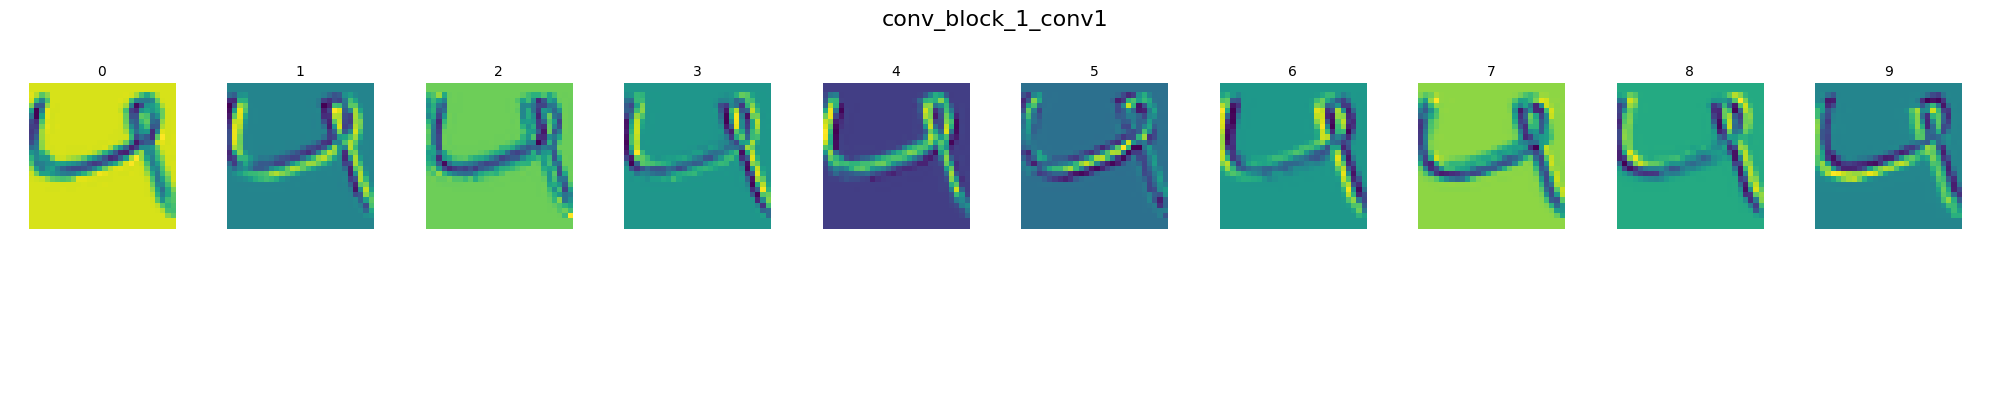

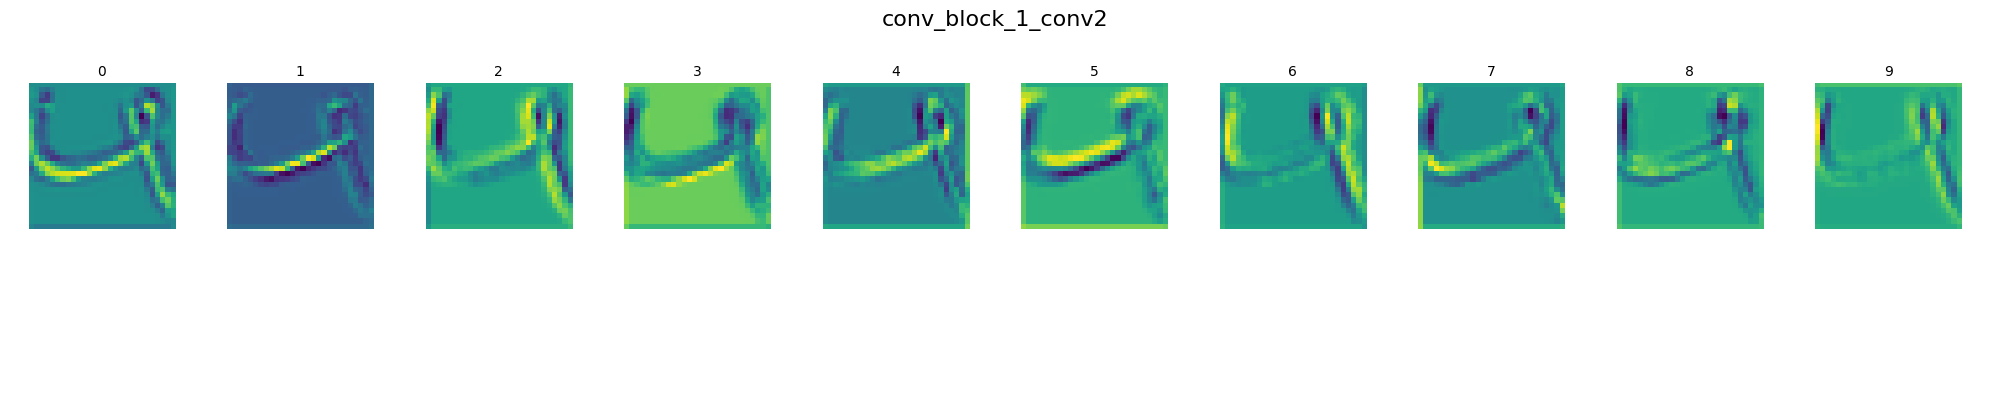

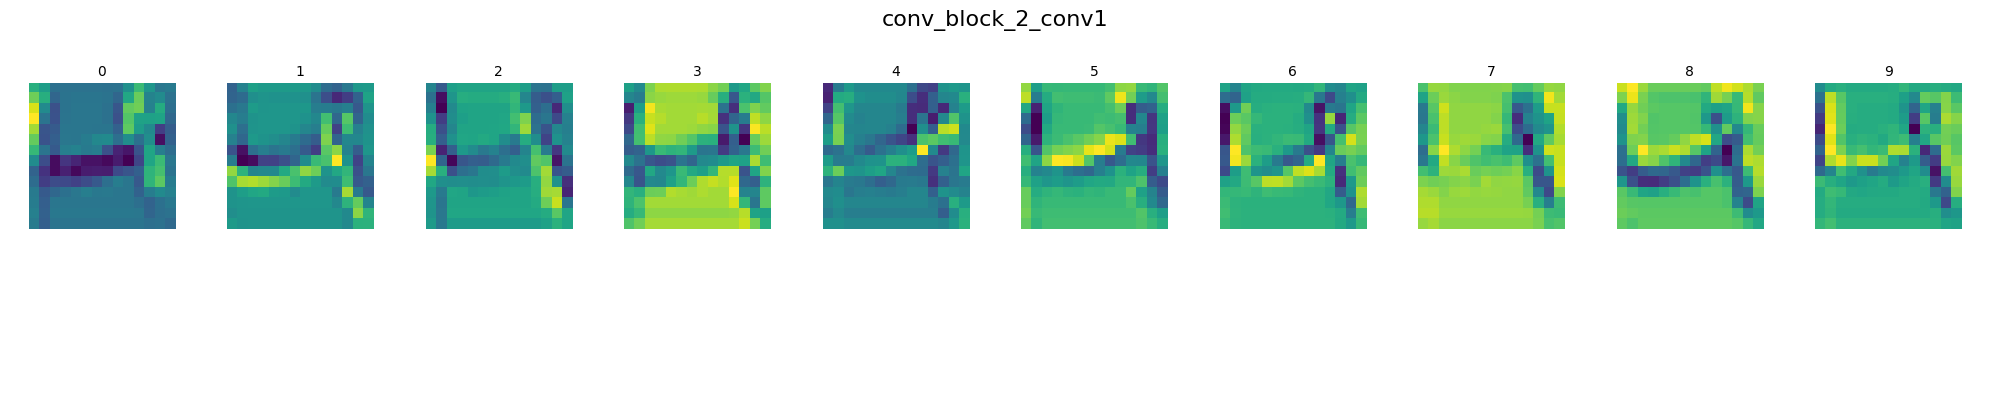

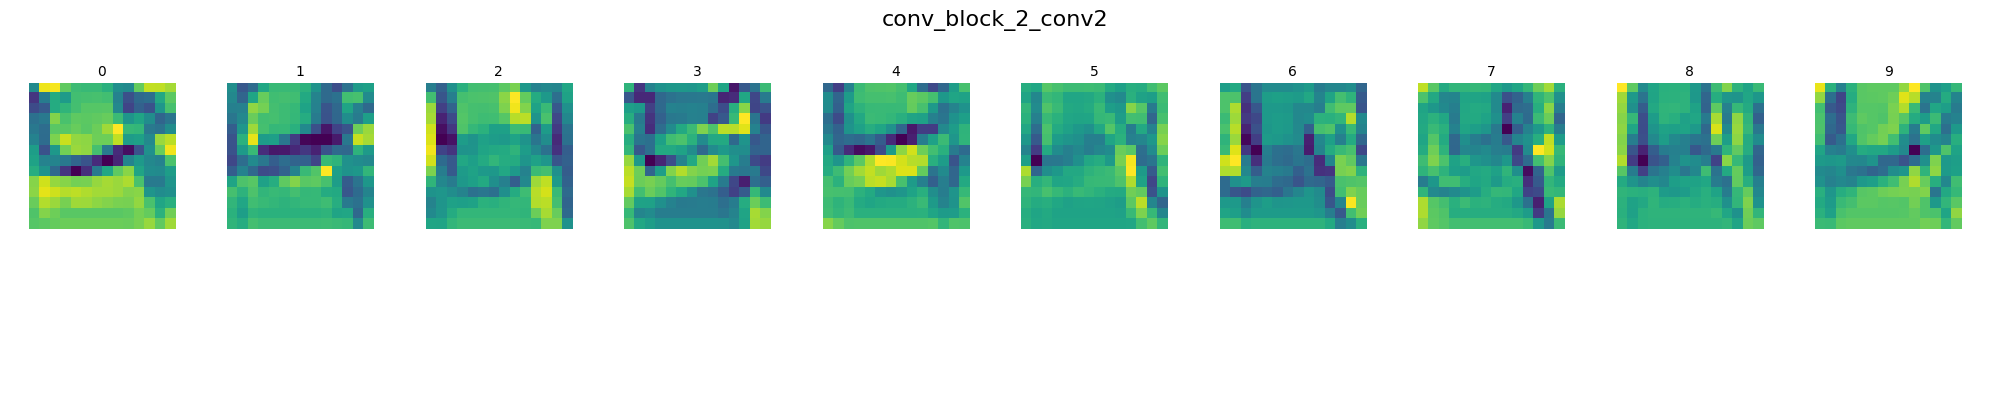

In [ ]:
#Visualize Neuron in CNN in previous part
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


def plot_activations(activation, title, num_cols=10):
    num_activations = activation.shape[1]
    num_rows = (num_activations // num_cols) + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i in range(num_activations):
        npimg = activation[0, i].cpu().numpy()
        axes[i].imshow(npimg, cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'{i}', fontsize=10)

    # Turn off any remaining empty subplots
    for j in range(num_activations, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Register hooks
activations = {}
model_cnn.conv_block_1[0].register_forward_hook(get_activation(' '))
model_cnn.conv_block_1[2].register_forward_hook(get_activation('conv_block_1_conv2'))
model_cnn.conv_block_2[0].register_forward_hook(get_activation('conv_block_2_conv1'))
model_cnn.conv_block_2[2].register_forward_hook(get_activation('conv_block_2_conv2'))

# Perform a forward pass to capture the activations
img.to("cpu")
model_cnn.to("cpu")
output = model_cnn(img.unsqueeze(0))

# Plot activations
for layer_name, activation in activations.items():
    plot_activations(activation, title=layer_name)

In [34]:
from typing import Tuple, Dict
from timeit import default_timer as timer
from scipy.ndimage import center_of_mass, shift
from torch.nn.functional import interpolate
import torch

def predict(img: torch.Tensor) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns the top 10 predictions and time taken."""
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = transform_image(img).unsqueeze(0)

    model_vgg.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model_vgg(img), dim=1)

    # Get the top 10 prediction probabilities and their corresponding indices
    top_probs, top_indices = torch.topk(pred_probs, 10, dim=1)

    # Convert the top probabilities and indices to a dictionary
    pred_labels_and_probs = {class_names[top_indices[0][i].item()]: float(top_probs[0][i]) for i in range(10)}

    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time


In [36]:
import gradio as gr

# Create title, description and article strings
title = "Character and digit classify"
description = "Upload your image of character or digit"
article = "The product of group 30 - Mini Project IT3190E"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=len(class_names), label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e0a8830b493fc7c688.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
